<a href="https://colab.research.google.com/github/jorgeerrz/mistaken_mice/blob/master/GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
#@markdown Data retrieval

#Data retrieval
import os, requests
import numpy as np

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
        
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]

In [7]:
#@markdown Filter function, {V1, [-500ms,500ms], unfair trials}

#this function will do the filtering
def filter_spikes(alldata, session_id):
    #alldata is the collated data from all sessions/neurons/timepoints as shown in the tutorial notebook
    #grab spikes/choices from one section
    dat = alldat[session_id]
    spks = dat['spks']
    chcs = dat['response']
    RTs = dat['response_time']
    
    #grab only spikes/choices from trials where left/right contrast is equal and nonzero
    unfair_filter = np.logical_and((dat['contrast_right']==dat['contrast_left']), (dat['contrast_right'] != 0))
    unfair_chosey_filter = np.logical_and(unfair_filter,(dat['response']!=0))
    spks = spks[:,unfair_chosey_filter,:]
    chcs = chcs[unfair_chosey_filter]
    RTs = RTs[unfair_chosey_filter]
    
    #grab only spikes from the VISp
    spks = spks[dat['brain_area']=='VISp',:,:]
    
    #grab only spikes from between -500ms and 500ms, relative to stimulus onset (each bin is 10ms)
    spks = spks[:,:,0:100]
    
    return spks, chcs, RTs

In [63]:
#@markdown Helper functions
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Feature x time")
  f.tight_layout()

def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  #############################################################################
  # TODO Complete the function, then remove the next line to test it
  #raise NotImplementedError("Implement the compute_accuracy function")
  #############################################################################
  feat_reshaped = reshaping_features(X)
  y_pred = model.predict(feat_reshaped)
  accuracy = 1 - np.mean(y_pred - y) #np.mean(y == y_pred) 

  return accuracy

In [8]:
spks_f, chcs_f, RTs_f = filter_spikes(alldat,11)
print("we have", chcs_f.shape[0], "trials to use and ", spks_f.shape[0], "neurons")

we have 18 trials to use and  66 neurons


In [48]:
def reshaping_features(features, axis_pc = 0, axis_trial = 1, axis_time = 2):
  """Function to reshape N x trials x time into a single array, N is number of neurons or PCs
  Output: a matrix with shape trials x (N+time)
  the dimension N + time was concatenated by time, i.e. the first N entries correspond to the N features at time = 0, and so on.
  """
  out = np.zeros((features.shape[axis_trial],features.shape[axis_pc]*features.shape[axis_time]))
  for i in range(features.shape[axis_trial]):
    out[i,:] = features[:,i,:].T.flatten()
  return out

In [57]:
def GLM_logistic(features, choices, pen = "l2", lambda_L2 = 1):
  """Logistic regression already implemented in sci-kit learn"""
  feat_reshaped = reshaping_features(features)
  if pen == "l1":
    log_reg = LogisticRegression(penalty=pen, C = lambda_L2, solver="saga", max_iter=5000).fit(feat_reshaped,choices)
  else: 
    log_reg = LogisticRegression(penalty=pen, C = lambda_L2).fit(feat_reshaped,choices)
  return log_reg

In [58]:
log_reg_l2 = GLM_logistic(spks_f, chcs_f)
log_reg_l1 = GLM_logistic(spks_f, chcs_f, pen = "l1")

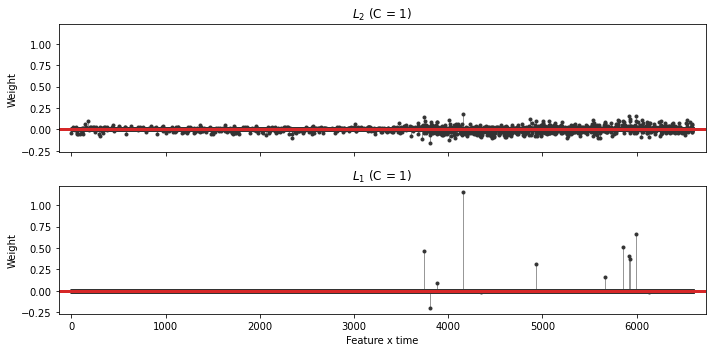

In [59]:
models = {
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
plot_weights(models)

In [67]:
# To test the function we will use neurons x time as features for now
train_accuracy = compute_accuracy(spks_f, chcs_f, log_reg_l1)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%
